In [1]:
import torch 
import torch.nn as nn 
import torchvision.transforms.functional as tf

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class U_Net(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features = [64, 128, 256, 512]):
        super(U_Net, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        # max pools will floor inputs unless divisible by 16 - we can make the implementation general
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = tf.resize(x, size=skip_connection.shape) # as it will always be smaller


            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)


In [3]:
x = torch.randn((3, 1, 160,160))
model = U_Net(in_channels=1, out_channels=1)
preds = model(x)
print(preds.shape)
print(x.shape)
assert preds.shape == x.shape


torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [4]:
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class MugDataset(Dataset):
    def __init__(self, image_dir, transform=None, image_size=(256, 256)):
        self.image_dir = image_dir
        self.transform = transform
        self.image_size = image_size
        self.images = sorted([x for x in os.listdir(image_dir) if "label" not in x])

        # Define a default transform to resize images
        self.default_transform = T.Compose([
            T.Resize(image_size),  # Resize all images to the same size
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = img_path.replace(".jpg", "_label.png")

        # Load and resize image
        image = Image.open(img_path).convert("RGB")
        image = self.default_transform(image)  # Resized to (C, H, W)

        # Load and resize mask (if it exists)
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert("L")  # Convert to grayscale
            mask = self.default_transform(mask)
        else:
            mask = torch.zeros((1, *self.image_size))  # Create an empty mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask


In [5]:
from torch.utils.data import DataLoader

# Define dataset
dataset = MugDataset(image_dir="Mugs", transform=None)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

# Example usage
for images, masks in dataloader:
    print(images.shape, masks.shape)  # Check batch shapes
    break  # Just to see one batch


torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])


In [6]:
from tqdm import tqdm 
import torch.optim as optim 

lr =1e-4
device = "cuda" 
batch_size = 4
num_epochs = 3
num_workers = 1
height = 97
width = 120

img_dir = "Mugs"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.float().to(device=device)


        predictions = model(data)
        loss = loss_fn(predictions, targets)
    
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    loop.set_postfix(loss = loss.item())


model = U_Net(in_channels=3, out_channels=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)



In [7]:
from torch.cuda.amp import GradScaler  # ✅ Import GradScaler

scaler = GradScaler()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    train_fn(train_loader, model, optimizer, loss_fn, scaler)


/tmp/ipykernel_39788/1314108186.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/3:


100%|██████████| 53/53 [00:09<00:00,  5.62it/s]


Epoch 2/3:


100%|██████████| 53/53 [00:09<00:00,  5.72it/s]


Epoch 3/3:


100%|██████████| 53/53 [00:09<00:00,  5.72it/s]


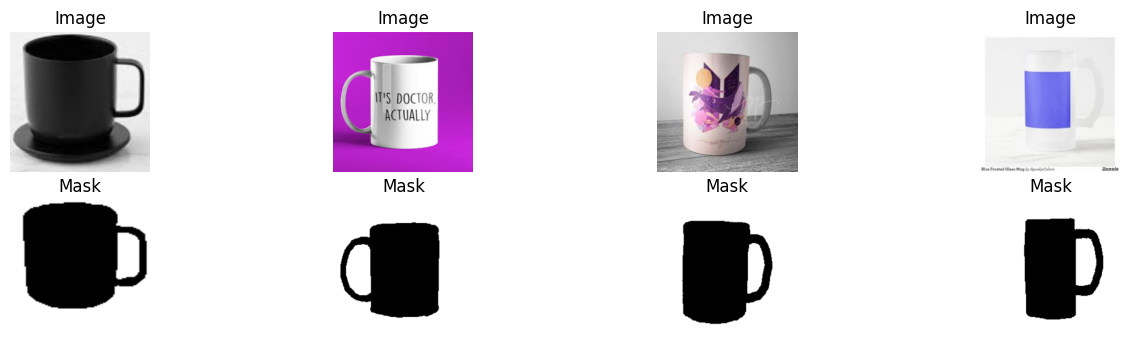

In [10]:
import matplotlib.pyplot as plt
def visualize_data(loader):
    images, masks = next(iter(loader))
    images, masks = images[:8], masks[:8]  # Show 8 samples

    # Convert tensors to NumPy
    images = images.permute(0, 2, 3, 1).cpu().numpy()  # (B, H, W, C)
    masks = masks.squeeze(1).cpu().numpy()  # (B, H, W)

    fig, axes = plt.subplots(2, 4, figsize=(16, 4))
    for i in range(4):
        axes[0, i].imshow(images[i])
        axes[0, i].set_title("Image")
        axes[0, i].axis("off")

        axes[1, i].imshow(masks[i], cmap="gray")
        axes[1, i].set_title("Mask")
        axes[1, i].axis("off")

    plt.show()

# ✅ Call visualization
visualize_data(train_loader)